# 머신러닝을 활용한 SMS 필터링

## 1. 데이터 수집 및 불러오기

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics 
from sklearn.model_selection import KFold
import seaborn as sns
import time

In [176]:
email = pd.read_csv('spam.csv',encoding = 'utf-8')
del email['Unnamed: 2']
del email['Unnamed: 3']
del email['Unnamed: 4']
email.columns = ['label','text']

In [177]:
email

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ? b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


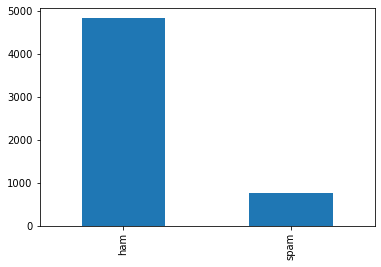

In [178]:
email.label.value_counts().plot.bar();

## 2. 데이터 전처리

In [179]:
emails = email['text']
emails

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                 Will ? b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: text, Length: 5572, dtype: object

### 문장 기호 제거

In [180]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [181]:
def remove_punctuation(text):
    cleaned_text=''.join([char for char in text if char not in string.punctuation])
    cleaned_text= cleaned_text.lower()
    return cleaned_text




In [182]:
email['cleaned_text']=email['text'].apply(lambda row : remove_punctuation(row))
email.head()

,label,text,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in 2 a wkly comp to win fa cup fina...
3,ham,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [183]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
stop_words = stopwords.words('english') + ['u', 'ü', 'ur', 'im', 'dont', 'doin', 'ure']


lemma = WordNetLemmatizer() 

emails = email['cleaned_text']
emails


0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2       free entry in 2 a wkly comp to win fa cup fina...
3             u dun say so early hor u c already then say
4       nah i dont think he goes to usf he lives aroun...
                              ...                        
5567    this is the 2nd time we have tried 2 contact u...
5568                   will  b going to esplanade fr home
5569    pity  was in mood for that soany other suggest...
5570    the guy did some bitching but i acted like id ...
5571                            rofl its true to its name
Name: cleaned_text, Length: 5572, dtype: object

### 단어들을 모두 원형화

In [184]:
def preprocessing(emails): # 원형화해주는 함수
    result = []
    for i in emails:
        clean = ''
        d = i.split()
        for j in d:
            if j not in stop_words and j.isalpha():
                clean += lemma.lemmatize(j,'v') + ' '
        result.append(clean)
    return result

In [185]:
email['cleaned_text'] = preprocessing(emails)
email

,label,text,cleaned_text
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts may...
3,ham,U dun say so early hor... U c already then say...,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think go usf live around though
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,time try contact pound prize claim easy call p...
5568,ham,Will ? b going to esplanade fr home?,b go esplanade fr home
5569,ham,"Pity, * was in mood for that. So...any other s...",pity mood soany suggestions
5570,ham,The guy did some bitching but I acted like i'd...,guy bitch act like id interest buy something e...


### 단어별 빈도 출력 ( 상위 50개 )

In [186]:
from collections import Counter

words = email[email.label=='ham'].cleaned_text.apply(lambda x: [word.lower() for word in x.split()])
ham_words = Counter()

for text in words:
    ham_words.update(text)
    
print(ham_words.most_common(50))

[('get', 594), ('go', 516), ('come', 318), ('call', 287), ('ltgt', 276), ('ok', 272), ('know', 257), ('like', 239), ('ill', 236), ('say', 224), ('good', 222), ('time', 219), ('love', 219), ('want', 212), ('think', 198), ('send', 193), ('tell', 191), ('day', 187), ('need', 175), ('see', 165), ('take', 162), ('make', 162), ('one', 162), ('home', 160), ('lor', 160), ('sorry', 153), ('still', 146), ('n', 134), ('later', 134), ('da', 131), ('work', 131), ('r', 131), ('back', 129), ('meet', 126), ('well', 126), ('ask', 126), ('today', 125), ('cant', 118), ('hi', 117), ('give', 116), ('miss', 116), ('much', 112), ('oh', 111), ('leave', 111), ('night', 107), ('hey', 106), ('happy', 105), ('great', 100), ('way', 100), ('hope', 99)]


In [187]:
words = email[email.label=='spam'].cleaned_text.apply(lambda x: [word.lower() for word in x.split()])
spam_words = Counter()

for text in words:
    spam_words.update(text)
    
print(spam_words.most_common(30))

[('call', 366), ('free', 216), ('txt', 150), ('mobile', 123), ('text', 120), ('claim', 115), ('stop', 113), ('reply', 109), ('prize', 94), ('get', 94), ('send', 79), ('tone', 73), ('service', 72), ('new', 69), ('award', 66), ('nokia', 65), ('urgent', 63), ('win', 62), ('cash', 62), ('contact', 61), ('phone', 57), ('please', 55), ('guarantee', 50), ('customer', 49), ('week', 49), ('per', 46), ('message', 45), ('chat', 44), ('draw', 39), ('number', 39)]


In [188]:
hamWords = email[email['label'] == 'ham'].cleaned_text
spamWords = email[email['label'] == 'spam'].cleaned_text

## 워드클라우드 시각화

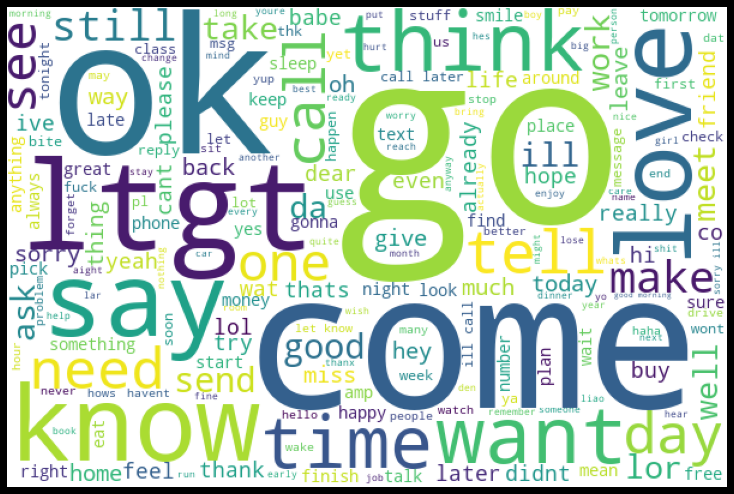

In [189]:
from wordcloud import WordCloud

spam_wordcloud = WordCloud(background_color='white',width=600, height=400).generate(" ".join(hamWords))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

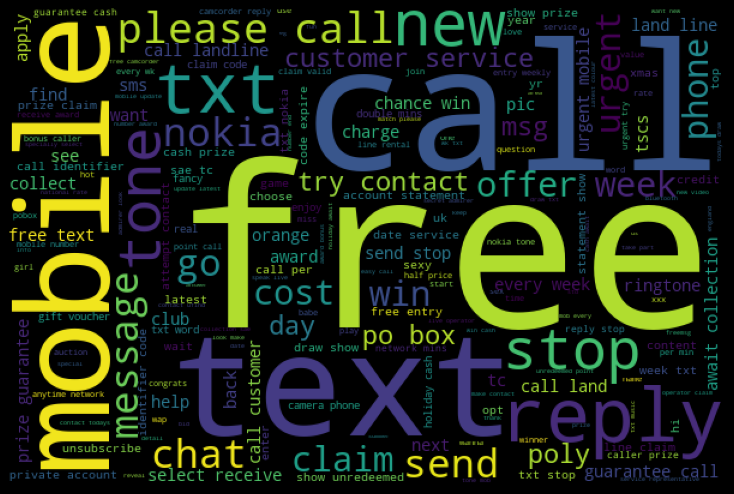

In [190]:
from wordcloud import WordCloud

spam_wordcloud = WordCloud(background_color='black',width=600, height=400).generate(" ".join(spamWords))
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## 3. 모델 학습 

In [191]:
X = email.cleaned_text
y = email.label


### 데이터 분리

In [192]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(4457,)
(1115,)
(4457,)
(1115,)


In [193]:
print(y_train.value_counts())

ham     3849
spam     608
Name: label, dtype: int64


### train 데이터

In [194]:
print(X_train)

1642                                  sleep nt feel well 
2899                   come aftr ltdecimalgt clean house 
480                                       almost see sec 
3485                               yeah probably earlier 
157     hello love get interview today happy good boy ...
                              ...                        
905                   hey whats charles sorry late reply 
5192      oh oh den muz change plan liao go back yan jiu 
3980                        huh cant thk oredi many page 
235                          print oh ltgt come upstairs 
5157                                        k k sms chat 
Name: cleaned_text, Length: 4457, dtype: object


In [195]:
print(y_test.value_counts())

ham     976
spam    139
Name: label, dtype: int64


### CountVectorizer (단어 카운트)

In [196]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [197]:
print(X_train)
print(X_train.shape)

1642                                  sleep nt feel well 
2899                   come aftr ltdecimalgt clean house 
480                                       almost see sec 
3485                               yeah probably earlier 
157     hello love get interview today happy good boy ...
                              ...                        
905                   hey whats charles sorry late reply 
5192      oh oh den muz change plan liao go back yan jiu 
3980                        huh cant thk oredi many page 
235                          print oh ltgt come upstairs 
5157                                        k k sms chat 
Name: cleaned_text, Length: 4457, dtype: object
(4457,)


In [198]:

X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)
print(X_train_dtm)
#X_train 에, (a,b)  c
#a번째 메일에, b라는 index를 가진 단어가 c번 들어간다
#고로, X_train_dtm = 메일에 들어간 단어의 빈도 수를 나타내는 matrix

  (0, 4942)	1
  (0, 3773)	1
  (0, 1839)	1
  (0, 6017)	1
  (1, 1040)	1
  (1, 103)	1
  (1, 3198)	1
  (1, 988)	1
  (1, 2497)	1
  (2, 170)	1
  (2, 4741)	1
  (2, 4731)	1
  (3, 6259)	1
  (3, 4281)	1
  (3, 1573)	1
  (4, 2367)	1
  (4, 3177)	1
  (4, 2111)	1
  (4, 2688)	1
  (4, 5577)	1
  (4, 2313)	1
  (4, 2169)	1
  (4, 650)	1
  (4, 5497)	1
  (4, 3336)	1
  :	:
  (4452, 3010)	1
  (4452, 892)	1
  (4453, 2148)	1
  (4453, 3830)	2
  (4453, 418)	1
  (4453, 4116)	1
  (4453, 3590)	1
  (4453, 3066)	1
  (4453, 884)	1
  (4453, 1342)	1
  (4453, 6250)	1
  (4453, 2806)	1
  (4454, 3900)	1
  (4454, 806)	1
  (4454, 5503)	1
  (4454, 2530)	1
  (4454, 3283)	1
  (4454, 3955)	1
  (4455, 1040)	1
  (4455, 3201)	1
  (4455, 3830)	1
  (4455, 4267)	1
  (4455, 5802)	1
  (4456, 898)	1
  (4456, 4981)	1


In [199]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)

token_import_mat = tfidf_transformer.transform(X_train_dtm) 
print(token_import_mat)
#고로, X_train_dtm = 메일에 들어간 단어의 빈도 수를 나타내는 matrix
#tfidf_transformer 설명
#X_train_dtm을 input으로 넣으면, token의 중요도를 나타내는 matrix가 output이 된다

  (0, 6017)	0.42577187375198217
  (0, 4942)	0.47205818826144663
  (0, 3773)	0.619011715918957
  (0, 1839)	0.46119830222163144
  (1, 3198)	0.4566914786102768
  (1, 2497)	0.42988035427483573
  (1, 1040)	0.27530047957247133
  (1, 988)	0.5009052010978073
  (1, 103)	0.5290929973394407
  (2, 4741)	0.38710388293783393
  (2, 4731)	0.6930817707227604
  (2, 170)	0.6081021648590429
  (3, 6259)	0.49988033039435464
  (3, 4281)	0.5804130743553378
  (3, 1573)	0.6428377076698409
  (4, 5577)	0.2503228596830984
  (4, 5497)	0.22950214041971667
  (4, 3441)	0.2664749394438024
  (4, 3336)	0.46455863297163463
  (4, 3177)	0.23355526470002902
  (4, 2688)	0.41568325119507155
  (4, 2367)	0.3103848339477974
  (4, 2313)	0.2796946378512058
  (4, 2169)	0.22453665314714868
  (4, 2111)	0.16951053618342946
  :	:
  (4452, 2396)	0.3473760112722645
  (4452, 892)	0.5774035665303973
  (4453, 6250)	0.3638372329146536
  (4453, 4116)	0.2644273692061062
  (4453, 3830)	0.470900834525961
  (4453, 3590)	0.33941668315666984
  (4453

## SVM

In [223]:
from sklearn.svm import SVC

svm_X = email.cleaned_text
svm_y = email.label


In [224]:
from sklearn.model_selection import train_test_split
svmX_train, svmX_test, svmy_train, svmy_test = train_test_split(svm_X, svm_y, test_size = 0.2,random_state=1)
svmX_train_dtm = vect.fit_transform(svmX_train)
svmX_test_dtm = vect.transform(svmX_test)



In [225]:

print("k-fold 아닌 경우")
linear_classifier = SVC(kernel='linear')
linear_classifier.fit(svmX_train_dtm,svmy_train)
y_pred = linear_classifier.predict(svmX_test_dtm)
linear_score = metrics.accuracy_score(svmy_test, y_pred)


print('Linear: ',round(100*linear_score,2),'%')



k-fold 아닌 경우
Linear:  98.74 %


### Linear Kernel

TRAIN: [   0    2    3 ... 5568 5569 5571] TEST: [   1   13   18 ... 5551 5567 5570]
TRAIN: [   0    1    2 ... 5567 5570 5571] TEST: [   6    9   12 ... 5565 5568 5569]
TRAIN: [   0    1    3 ... 5569 5570 5571] TEST: [   2    7    8 ... 5559 5560 5563]
TRAIN: [   1    2    3 ... 5569 5570 5571] TEST: [   0    4    5 ... 5558 5562 5564]
TRAIN: [   0    1    2 ... 5568 5569 5570] TEST: [   3   10   11 ... 5561 5566 5571]
Linear:  98.04 %
time : 3.2904722690582275


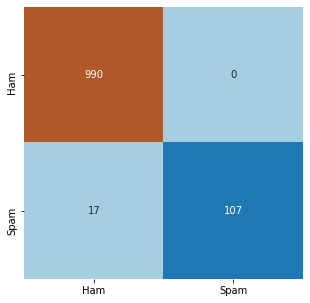

In [226]:
start = time.time()
kf = KFold(n_splits=5,shuffle = True)
sum = 0
svmk_X = email.cleaned_text
svmk_y = email.label
svm_kf = KFold(n_splits=5,shuffle = True)
svm_accuracy = []


for train_index, test_index in kf.split(svmk_X): 
    print("TRAIN:", train_index, "TEST:", test_index)
    svmk_X_train, svmk_X_test = svmk_X[train_index], svmk_X[test_index]
    svmk_y_train, svmk_y_test = svmk_y[train_index], svmk_y[test_index]
    svmk_X_train_dtm = vect.fit_transform(svmk_X_train)
    svmk_X_test_dtm = vect.transform(svmk_X_test)
    linear_classifier = SVC(kernel='linear',probability=False)
    linear_classifier.fit(svmk_X_train_dtm,svmk_y_train)
    linear_ypred = linear_classifier.predict(svmk_X_test_dtm)
    svm_linear_score = metrics.accuracy_score(svmk_y_test, linear_ypred)
    svm_accuracy.append(svm_linear_score)
 

print('Linear: ',round(100*np.mean(svm_accuracy),2),'%')
confusion_mat = metrics.confusion_matrix(svmk_y_test, linear_ypred)
plt.figure(figsize = (5,5))
sns.heatmap(confusion_mat, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam']);

print("time :", time.time() - start) 

TRAIN: [   0    1    4 ... 5569 5570 5571] TEST: [   2    3    5 ... 5558 5559 5566]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [   8   15   19 ... 5565 5567 5568]
TRAIN: [   0    2    3 ... 5567 5568 5571] TEST: [   1    9   13 ... 5556 5569 5570]
TRAIN: [   0    1    2 ... 5568 5569 5570] TEST: [   4   12   20 ... 5546 5557 5571]
TRAIN: [   1    2    3 ... 5569 5570 5571] TEST: [   0   10   16 ... 5554 5561 5562]
Linear:  98.12 %
time : 12.151672840118408


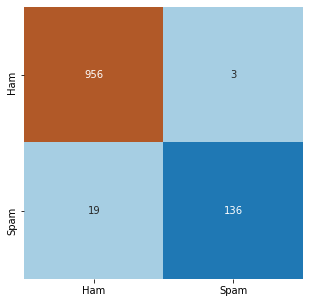

In [227]:
start = time.time()

svmk_X = email.cleaned_text
svmk_y = email.label
svm_kf = KFold(n_splits=5,shuffle = True)
svm_accuracy = []


for train_index, test_index in kf.split(svmk_X): 
    print("TRAIN:", train_index, "TEST:", test_index)
    svmk_X_train, svmk_X_test = svmk_X[train_index], svmk_X[test_index]
    svmk_y_train, svmk_y_test = svmk_y[train_index], svmk_y[test_index]
    svmk_X_train_dtm = vect.fit_transform(svmk_X_train)
    svmk_X_test_dtm = vect.transform(svmk_X_test)
    linear_classifier = SVC(kernel='linear',probability=True)
    linear_classifier.fit(svmk_X_train_dtm,svmk_y_train)
    linear_ypred = linear_classifier.predict(svmk_X_test_dtm)
    svm_linear_score = metrics.accuracy_score(svmk_y_test, linear_ypred)
    svm_accuracy.append(svm_linear_score)
 

print('Linear: ',round(100*np.mean(svm_accuracy),2),'%')
confusion_mat = metrics.confusion_matrix(svmk_y_test, linear_ypred)
plt.figure(figsize = (5,5))
sns.heatmap(confusion_mat, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam']);

print("time :", time.time() - start) 

- Probability = False(확률 추정 사용하지않음)로 하면 약 1.77초, True(확률 추정 사용)로 하면 약 7초가 걸린다.
- 정확도는 비슷한데, 시간적인 측면에서 Probability = False로 하는 것이 러닝타임이 훨씬 짧으므로 더욱 성능이 좋다

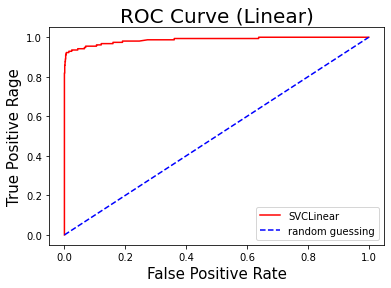

In [228]:
from sklearn.metrics import roc_curve, roc_auc_score
svmk_y_pred_proba = linear_classifier.predict_proba(svmk_X_test_dtm)
fpr, tpr, _ = roc_curve(svmk_y_test,svmk_y_pred_proba[:, 1], pos_label='spam')
auc = roc_auc_score(svmk_y_test,svmk_y_pred_proba[:, 1])
plt.plot(fpr,tpr,"r-", label = "SVCLinear")
plt.plot([0,1],[0,1],"b--", label = "random guessing")
plt.xlabel("False Positive Rate",size = 15)
plt.ylabel("True Positive Rage",size = 15)
plt.title('ROC Curve (Linear)', size=20)
plt.legend(loc="lower right")
plt.show()

### Poly Kernel

TRAIN: [   1    2    3 ... 5568 5569 5570] TEST: [   0   11   18 ... 5556 5567 5571]
TRAIN: [   0    1    2 ... 5567 5569 5571] TEST: [   3   14   22 ... 5563 5568 5570]
TRAIN: [   0    1    2 ... 5568 5570 5571] TEST: [  13   17   30 ... 5557 5564 5569]
TRAIN: [   0    1    3 ... 5569 5570 5571] TEST: [   2    5   10 ... 5549 5554 5565]
TRAIN: [   0    2    3 ... 5569 5570 5571] TEST: [   1    4    6 ... 5560 5562 5566]
Poly:  94.51 %
time : 13.94581127166748


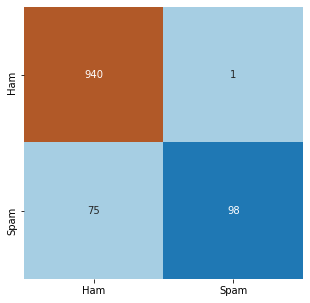

In [229]:
start = time.time()

svm_kf = KFold(n_splits=5,shuffle = True)
svm_accuracy = []

for train_index, test_index in kf.split(svmk_X): 
    print("TRAIN:", train_index, "TEST:", test_index)
    svmk_X_train, svmk_X_test = svmk_X[train_index], svmk_X[test_index]
    svmk_y_train, svmk_y_test = svmk_y[train_index], svmk_y[test_index]
    svmk_X_train_dtm = vect.fit_transform(svmk_X_train)
    svmk_X_test_dtm = vect.transform(svmk_X_test)
    poly_classifier = SVC(kernel='poly', probability = False)
    poly_classifier.fit(svmk_X_train_dtm,svmk_y_train)
    poly_ypred = poly_classifier.predict(svmk_X_test_dtm)
    svm_poly_score = metrics.accuracy_score(svmk_y_test, poly_ypred)
    svm_accuracy.append(svm_poly_score)

print('Poly: ',round(100*np.mean(svm_accuracy),2),'%')
confusion_mat = metrics.confusion_matrix(svmk_y_test, poly_ypred)
plt.figure(figsize = (5,5))
sns.heatmap(confusion_mat, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam']);

print("time :", time.time() - start) 

TRAIN: [   0    1    3 ... 5567 5568 5570] TEST: [   2    6    7 ... 5562 5569 5571]
TRAIN: [   1    2    4 ... 5569 5570 5571] TEST: [   0    3    5 ... 5560 5564 5565]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [   9   14   16 ... 5549 5556 5561]
TRAIN: [   0    2    3 ... 5569 5570 5571] TEST: [   1    8   10 ... 5557 5563 5567]
TRAIN: [   0    1    2 ... 5567 5569 5571] TEST: [   4   13   26 ... 5566 5568 5570]
Poly:  94.78 %
time : 64.20730352401733


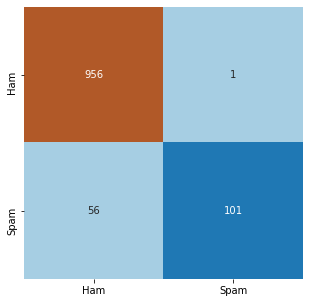

In [230]:
start = time.time()

svm_kf = KFold(n_splits=5,shuffle = True)
svm_accuracy = []

for train_index, test_index in kf.split(svmk_X): 
    print("TRAIN:", train_index, "TEST:", test_index)
    svmk_X_train, svmk_X_test = svmk_X[train_index], svmk_X[test_index]
    svmk_y_train, svmk_y_test = svmk_y[train_index], svmk_y[test_index]
    svmk_X_train_dtm = vect.fit_transform(svmk_X_train)
    svmk_X_test_dtm = vect.transform(svmk_X_test)
    poly_classifier = SVC(kernel='poly', probability = True)
    poly_classifier.fit(svmk_X_train_dtm,svmk_y_train)
    poly_ypred = poly_classifier.predict(svmk_X_test_dtm)
    svm_poly_score = metrics.accuracy_score(svmk_y_test, poly_ypred)
    svm_accuracy.append(svm_poly_score)

print('Poly: ',round(100*np.mean(svm_accuracy),2),'%')
confusion_mat = metrics.confusion_matrix(svmk_y_test, poly_ypred)
plt.figure(figsize = (5,5))
sns.heatmap(confusion_mat, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam']);

print("time :", time.time() - start) 

- Poly Kernel 경우에는 Probability = False(확률 추정 사용하지않음)로 하면 약 7초걸리지만, True(확률 추정 사용)로 하면 약 64초씩이나 걸린다.

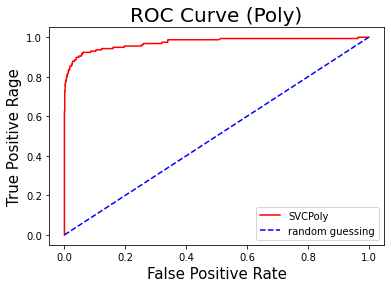

In [231]:
from sklearn.metrics import roc_curve, roc_auc_score
svmk_y_pred_proba = poly_classifier.predict_proba(svmk_X_test_dtm)
fpr, tpr, _ = roc_curve(svmk_y_test,svmk_y_pred_proba[:, 1], pos_label='spam')
auc = roc_auc_score(svmk_y_test,svmk_y_pred_proba[:, 1])
plt.plot(fpr,tpr,"r-", label = "SVCPoly")
plt.plot([0,1],[0,1],"b--", label = "random guessing")
plt.xlabel("False Positive Rate",size = 15)
plt.ylabel("True Positive Rage",size = 15)
plt.title('ROC Curve (Poly)', size=20)
plt.legend(loc="lower right")
plt.show()

### Sigmoid Kernel

TRAIN: [   0    1    2 ... 5568 5569 5570] TEST: [   6    9   11 ... 5557 5561 5571]
TRAIN: [   0    1    2 ... 5568 5570 5571] TEST: [   3    4   12 ... 5563 5565 5569]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [   5    7   19 ... 5556 5564 5566]
TRAIN: [   3    4    5 ... 5568 5569 5571] TEST: [   0    1    2 ... 5560 5562 5570]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [   8   10   16 ... 5550 5567 5568]
Sigmoid:  97.77 %
time : 3.2231690883636475


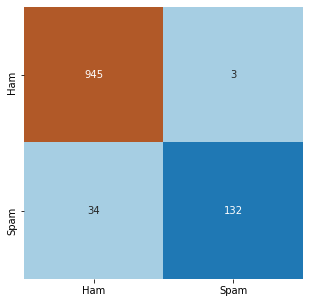

In [232]:
start = time.time()
svm_kf = KFold(n_splits=5,shuffle = True)
svm_accuracy = []

for train_index, test_index in kf.split(svmk_X): 
    print("TRAIN:", train_index, "TEST:", test_index)
    svmk_X_train, svmk_X_test = svmk_X[train_index], svmk_X[test_index]
    svmk_y_train, svmk_y_test = svmk_y[train_index], svmk_y[test_index]
    svmk_X_train_dtm = vect.fit_transform(svmk_X_train)
    svmk_X_test_dtm = vect.transform(svmk_X_test)
    sigmoid_classifier = SVC(kernel='sigmoid')
    sigmoid_classifier.fit(svmk_X_train_dtm,svmk_y_train)
    sigmoid_ypred = sigmoid_classifier.predict(svmk_X_test_dtm)
    svm_sigmoid_score = metrics.accuracy_score(svmk_y_test, sigmoid_ypred)
    svm_accuracy.append(svm_sigmoid_score)

print('Sigmoid: ',round(100*np.mean(svm_accuracy),2),'%')

confusion_mat = metrics.confusion_matrix(svmk_y_test, sigmoid_ypred)
plt.figure(figsize = (5,5))
sns.heatmap(confusion_mat, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam']);
print("time :", time.time() - start) 

In [233]:
sigmoid_classifier = SVC(kernel='sigmoid',probability = True)
sigmoid_classifier.fit(svmk_X_train_dtm,svmk_y_train)

SVC(kernel='sigmoid', probability=True)

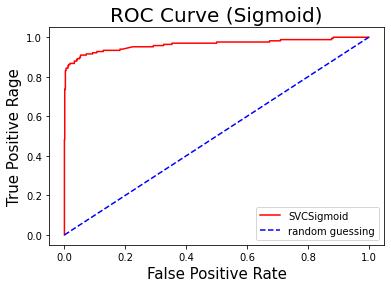

In [234]:
from sklearn.metrics import roc_curve, roc_auc_score
svmk_y_pred_proba = sigmoid_classifier.predict_proba(svmk_X_test_dtm)
fpr, tpr, _ = roc_curve(svmk_y_test,svmk_y_pred_proba[:, 1], pos_label='spam')
auc = roc_auc_score(svmk_y_test,svmk_y_pred_proba[:, 1])
plt.plot(fpr,tpr,"r-", label = "SVCSigmoid")
plt.plot([0,1],[0,1],"b--", label = "random guessing")
plt.xlabel("False Positive Rate",size = 15)
plt.ylabel("True Positive Rage",size = 15)
plt.title('ROC Curve (Sigmoid)', size=20)
plt.legend(loc="lower right")
plt.show()

### RBF Kernel

TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [   3    4    6 ... 5550 5554 5560]
TRAIN: [   0    1    2 ... 5568 5569 5570] TEST: [  18   20   25 ... 5564 5567 5571]
TRAIN: [   0    1    2 ... 5569 5570 5571] TEST: [   5   13   22 ... 5559 5561 5566]
TRAIN: [   0    1    2 ... 5568 5569 5571] TEST: [   8   10   11 ... 5557 5563 5570]
TRAIN: [   3    4    5 ... 5567 5570 5571] TEST: [   0    1    2 ... 5565 5568 5569]
Rbf:  97.74 %


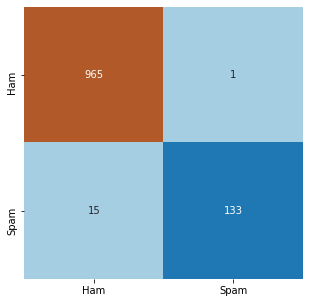

In [235]:
svm_kf = KFold(n_splits=5,shuffle = True)
svm_accuracy = []

for train_index, test_index in kf.split(svmk_X): 
    print("TRAIN:", train_index, "TEST:", test_index)
    svmk_X_train, svmk_X_test = svmk_X[train_index], svmk_X[test_index]
    svmk_y_train, svmk_y_test = svmk_y[train_index], svmk_y[test_index]
    svmk_X_train_dtm = vect.fit_transform(svmk_X_train)
    svmk_X_test_dtm = vect.transform(svmk_X_test)
    rbf_classifier = SVC(kernel='rbf')
    rbf_classifier.fit(svmk_X_train_dtm,svmk_y_train)
    rbf_ypred = rbf_classifier.predict(svmk_X_test_dtm)
    svm_rbf_score = metrics.accuracy_score(svmk_y_test, rbf_ypred)
    svm_accuracy.append(svm_rbf_score)

print('Rbf: ',round(100*np.mean(svm_accuracy),2),'%')

confusion_mat = metrics.confusion_matrix(svmk_y_test, rbf_ypred)
plt.figure(figsize = (5,5))
sns.heatmap(confusion_mat, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam']);

In [236]:
rbf_classifier = SVC(kernel='rbf',probability=True)
rbf_classifier.fit(svmk_X_train_dtm,svmk_y_train)

SVC(probability=True)

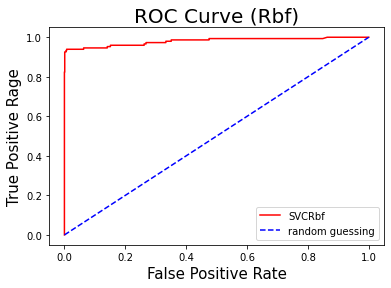

In [237]:
from sklearn.metrics import roc_curve, roc_auc_score
svmk_y_pred_proba = rbf_classifier.predict_proba(svmk_X_test_dtm)
fpr, tpr, _ = roc_curve(svmk_y_test,svmk_y_pred_proba[:, 1], pos_label='spam')
auc = roc_auc_score(svmk_y_test,svmk_y_pred_proba[:, 1])
plt.plot(fpr,tpr,"r-", label = "SVCRbf")
plt.plot([0,1],[0,1],"b--", label = "random guessing")
plt.xlabel("False Positive Rate",size = 15)
plt.ylabel("True Positive Rage",size = 15)
plt.title('ROC Curve (Rbf)', size=20)
plt.legend(loc="lower right")
plt.show()